torch.Size([64, 8, 32, 32]) torch.Size([64])
torch.Size([8, 32, 32])


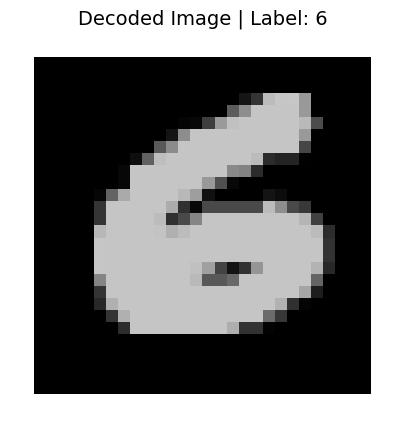

In [6]:
import lightning as L
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

DICT_SIZE = 200
MODEL_CHANNELS = 64
NUM_BITS = len(bin(DICT_SIZE - 1)) - 2


def int_to_binary_channels(tensor):
    # [bit_num, h, w])
    binary_tensor = torch.zeros(NUM_BITS, tensor.shape[0], tensor.shape[1])
    for i in range(NUM_BITS):
        binary_tensor[i, :, :] = (tensor >> i) & 1
    return torch.flip(binary_tensor, dims=[0])

### 0 is a mask token [1, 2, ..., dict_size-2] are the actual digits
class DigitDataModule(L.LightningDataModule):
    def __init__(self, dict_size: int, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                # 0.5 * 0 + 1
                # [0, 1] -> # [1, dict_size-1] with 0 mask token 
                transforms.Lambda(lambda x: (x[0] * (dict_size - 2) + 1).long()),
                transforms.Lambda(lambda x: int_to_binary_channels(x)),
                transforms.Pad((2, 2, 2, 2), fill=1, padding_mode="constant"),
            ]
        )

    def prepare_data(self):
        MNIST("MNIST", train=True, download=True)
        MNIST("MNIST", train=False, download=True)

    def setup(self, stage: str = "fit"):
        if stage == "fit":
            full_set = MNIST(
                root="MNIST",
                train=True,
                transform=self.transform,
                download=True,
            )
            train_set_size = int(len(full_set) * 0.8)
            val_set_size = len(full_set) - train_set_size
            seed = torch.Generator().manual_seed(42)
            (
                self.train_set,
                self.val_set,
            ) = data.random_split(  # Split train/val datasets
                full_set, [train_set_size, val_set_size], generator=seed
            )
        elif stage == "test":
            self.test_set = MNIST(
                root="MNIST",
                train=False,
                transform=self.transform,
            )

    def train_dataloader(self):
        return data.DataLoader(
            self.train_set, batch_size=self.batch_size, num_workers=10
        )

    def val_dataloader(self):
        return data.DataLoader(
            self.val_set, batch_size=self.batch_size, num_workers=10
        )

    def test_dataloader(self):
        return data.DataLoader(
            self.test_set, batch_size=self.batch_size, num_workers=10
        )
    
def binary_channels_to_int(binary_tensor):
    weights = 2 ** torch.arange(NUM_BITS - 1, -1, -1)
    weighted_channels = binary_tensor * weights.view(NUM_BITS, 1, 1)
    decoded_tensor = torch.sum(weighted_channels, dim=0)
    return decoded_tensor.long()

if __name__ == "__main__":

    dm = DigitDataModule(dict_size=DICT_SIZE)
    dm.prepare_data()
    dm.setup()

    train_loader = dm.train_dataloader()
    images, labels = next(iter(train_loader))
    print(images.shape, labels.shape)

    # 첫 번째 이미지 선택 및 디코딩
    encoded_image = images[0]
    print(encoded_image.shape)
    decoded_image = binary_channels_to_int(encoded_image)

    # 디코딩된 흑백 이미지만 시각화
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(decoded_image.numpy(), cmap='gray')
    ax.set_title(f"Decoded Image | Label: {labels[0].item()}", fontsize=14)
    ax.axis('off')
    plt.show()